In [1]:
from NetGEN.generation import CRNGen

# Path to data
datapath = "../../FluentData/ULBFurnace"

# Import the data creating a dictionary
datainfo = {}
datainfo["volume"] = "data_volumes"         # Cells volume (m3) MANDATORY
datainfo["angle"] = "data_angle"            # Velocity angle
datainfo["solution"] = "data_solution"      # Thermo-chemical solution MANDATORY
datainfo["density"] = "data_density"        # Density (kg/m3) 
datainfo["velocity"] = "data_velocity"      # Velocity magnitude
datainfo["tau"] = "data_tau"                # Residence time
datainfo["Tvar"] = "data_Trms"              # Temperature variance (K)

# Initialize the generator object
crngen = CRNGen()

In [2]:
# -------------- Preliminary steps ------------- #

# 1) Set the data dictionary
crngen.setDataDictionary(datainfo, datapath, 2)

# 2) Set the reference mesh graph for graph reassignemt
connfile = datapath + "/Neighbours_cell_flows"
crngen.setGraph(filepath=connfile, option='fluent')

# 3) Set the data to be used for clustering (default option "state-space")
crngen.setData(dataset = 'state-space')

Cluster  7  is disconnected in  2  components
There are  1  unconnected components in total
Cluster with only one cell found
Convergence reached, the clusters are now connected
Number of clusters matches number of reactors, exiting the function


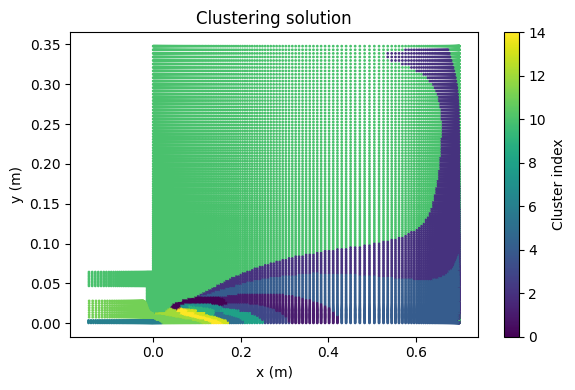

In [9]:
# -------------- Clustering steps ------------- #

# Select the number of clusters
k = 15

# Run the unsupervised + graph reassignment clustering for CRN generation
crngen.RunClustering(k, graph_reassign=True, reassign_method='volume', v_thresh=0.001, scaling='auto', verbose=True)

# Plot the clustering results on a scatter plot
crngen.plotClusters()

In [10]:
# -------------- Build and run CRN ------------- #

# Import cantera
import cantera as ct

# Select kinetic mechanism
cmech = "gri30.yaml"

# Fuel
g1 = ct.Solution("gri30.yaml")
g1.TPX = 300.0, 101325.0, "CH4:0.5, H2:0.5"

# Air
g2 = ct.Solution("gri30.yaml")
g2.TPX = 872.0, 101325.0, "O2:0.21, N2:0.79"

# Create the dictionary of the streams
fuel = {}
fuel['fluentid'] = 6
fuel['id'] = 0
fuel['name'] = 'fuel'
fuel['gas'] = g1

air = {}
air['fluentid'] = 15
air['id'] = 1
air['name'] = 'air'
air['gas'] = g2

# Streams must be a list of dictionaries. Each dictionary MUST contain:
# 'fluentid': id of the inlet in Fluent (if Fluent interface is used)
# 'id': must be ordered from 0 to number of inlet streams
# 'gas': reference Cantera solution (or Quantity) object identifying state
# 'name': custom name for the stream
streams = [fuel, air]

# Get mass flowrates
crngen.getMassFlowrates()

#  Read boundary cells file to get inlet streams
filepath = datapath + "/Boundary_cells"
crngen.getInletStreams(streams, filepath, verbose=True)

# Get attributes of the reactors
kincorr = True  # flag for using kinetic corrections
crngen.getReactorAttributes(kincorr=True, corrmethod='max')

# Check mass balance of the network
crngen.checkMassBalance(tol=1e-4, verbose=True)

# Set path to chemmkin-type kinetic mechanisms
kinfile     = "/Users/matteosavarese/Desktop/Dottorato/Kinetics/GRI3.0/gri30.CKI"
thermofile  = "/Users/matteosavarese/Desktop/Dottorato/Kinetics/GRI3.0/thermo.dat"
canteramech = 'gri30.cti' 

# Path to NetSMOKEpp.sh
netsmoke_path = "/Users/matteosavarese/Desktop/Dottorato/Github/NetSMOKEpp/SeReNetSMOKEpp-master/projects/Linux"
crn, crngen = crngen.setNetsmokeCRN(kinfile, thermofile, canteramech, netsmoke_path, verbose=True)
crn.RunSimulation(netsmoke_path, verbose=True)

Reactor  6  receive inlet from stream  0  called  fuel
Reactor  11  receive inlet from stream  1  called  air
Global imbalance of the network:  -3.110903705099385e-08
Max imbalance between reactors:  2.9488873753152642e-08
Reactor 6 is an inlet
Reactor 11 is an inlet
Reactor 10 is an outlet
-----------------------------------------------------------------------------

          ___                   ____  __  __  ___  _  _______                 
         / _ \ _ __   ___ _ __ / ___||  \/  |/ _ \| |/ / ____| _     _        
        | | | | '_ \ / _ \ '_ \\___ \| |\/| | | | | ' /|  _| _| |_ _| |_      
        | |_| | |_) |  __/ | | |___) | |  | | |_| | . \| |__|_   _|_   _|     
         \___/| .__/ \___|_| |_|____/|_|  |_|\___/|_|\_\_____||_|   |_|       
              |_|                                                             


           Department of Chemistry, Materials and Chemical Engineering        
                              Politecnico di Milano                       

In [11]:
# -------------- Post-process Network ------------- #
outputs = crn.ExtractOutputs()

for i in range(len(outputs)):
    ri = outputs[i]
    NO = outputs[i].X[g1.species_index('NO')]
    print(f"NO in Reactor {i} = {NO*1e6} ppm")

NO in Reactor 0 = 16.27417994262801 ppm
NO in Reactor 1 = 19.963491322465778 ppm
NO in Reactor 2 = 19.80470981966024 ppm
NO in Reactor 3 = 21.31079055283257 ppm
NO in Reactor 4 = 19.876830796409735 ppm
NO in Reactor 5 = 18.940340293937155 ppm
NO in Reactor 6 = 0.0031036129313488183 ppm
NO in Reactor 7 = 14.243581081027575 ppm
NO in Reactor 8 = 22.98313042996033 ppm
NO in Reactor 9 = 10.368010026511492 ppm
NO in Reactor 10 = 19.731711325349988 ppm
NO in Reactor 11 = 0.006951146743503133 ppm
NO in Reactor 12 = 4.513396879634185 ppm
NO in Reactor 13 = 6.2563848424960256 ppm
NO in Reactor 14 = 5.5328488046466955 ppm
NO in Reactor 15 = 0.0 ppm
NO in Reactor 16 = 3.567267999999999e-33 ppm
